# 1 Data preparation


First of all, to build a great classifying model, we should prepare our data so it fits correctly into it. We want to reescale our images to a correct size, in our case, to the minimum size of all images, which will find out in this script over here:

In [3]:
import os
import cv2
import skimage.feature
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os
import cv2

# Specify the paths to the main folders containing subfolders for train and test
train_folder_path = 'data/train'
test_folder_path = 'data/test'

# Initialize dictionaries to store the minimum width and height for each class
min_width_by_class = {}
min_height_by_class = {}

# Function to calculate the minimum size for a class folder
def calculate_min_size(class_folder_path):
    class_min_width = float('inf')
    class_min_height = float('inf')

    if os.path.isdir(class_folder_path):
        # Iterate through all the image files in the class folder
        for filename in os.listdir(class_folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                # Read the image using OpenCV
                image_path = os.path.join(class_folder_path, filename)
                image = cv2.imread(image_path)

                if image is not None:
                    # Get the dimensions of the image
                    height, width, _ = image.shape
                    class_min_width = min(class_min_width, width)
                    class_min_height = min(class_min_height, height)

        return class_min_width, class_min_height

# Process the train folder
for class_folder in os.listdir(train_folder_path):
    class_folder_path = os.path.join(train_folder_path, class_folder)
    min_width, min_height = calculate_min_size(class_folder_path)
    
    min_width_by_class[class_folder] = min_width
    min_height_by_class[class_folder] = min_height

# Process the test folder
for class_folder in os.listdir(test_folder_path):
    class_folder_path = os.path.join(test_folder_path, class_folder)
    min_width, min_height = calculate_min_size(class_folder_path)
    
    # Check if the class already exists in the dictionary
    if class_folder in min_width_by_class:
        # Update with the minimum values
        min_width_by_class[class_folder] = min(min_width_by_class[class_folder], min_width)
        min_height_by_class[class_folder] = min(min_height_by_class[class_folder], min_height)
    else:
        # Create new entries for the class
        min_width_by_class[class_folder] = min_width
        min_height_by_class[class_folder] = min_height

# Print the minimum width and height for each class from both folders
for class_name in min_width_by_class:
    min_width = min_width_by_class[class_name]
    min_height = min_height_by_class[class_name]
    print(f"Class: '{class_name}', Minimum Width: {min_width}, Minimum Height: {min_height}")


Class: 'bedroom', Minimum Width: 200, Minimum Height: 200
Class: 'Coast', Minimum Width: 200, Minimum Height: 200
Class: 'Forest', Minimum Width: 200, Minimum Height: 200
Class: 'Highway', Minimum Width: 200, Minimum Height: 200
Class: 'industrial', Minimum Width: 200, Minimum Height: 200
Class: 'Insidecity', Minimum Width: 200, Minimum Height: 200
Class: 'kitchen', Minimum Width: 200, Minimum Height: 200
Class: 'livingroom', Minimum Width: 200, Minimum Height: 200
Class: 'Mountain', Minimum Width: 200, Minimum Height: 200
Class: 'Office', Minimum Width: 200, Minimum Height: 200
Class: 'OpenCountry', Minimum Width: 200, Minimum Height: 200
Class: 'store', Minimum Width: 200, Minimum Height: 200
Class: 'Street', Minimum Width: 200, Minimum Height: 200
Class: 'Suburb', Minimum Width: 200, Minimum Height: 200
Class: 'TallBuilding', Minimum Width: 200, Minimum Height: 200
Class: 'coast', Minimum Width: 200, Minimum Height: 200
Class: 'forest', Minimum Width: 200, Minimum Height: 200
Class:

Conclusion: all images should be resized to 200x200 because bedroom has the minimum dimension size, its height.

# 1.2 Reescaling images 

In [5]:
# Specify the paths to the main folders containing subfolders for train and test
folder_paths = ['data/train', 'data/test']

# Specify the target size
target_width = 200
target_height = 200

# Function to resize images in a class folder
def resize_images_in_folder(class_folder_path):
    if os.path.isdir(class_folder_path):
        # Iterate through all the image files in the class folder
        for filename in os.listdir(class_folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                # Read the image using OpenCV
                image_path = os.path.join(class_folder_path, filename)
                image = cv2.imread(image_path)

                if image is not None:
                    # Resize the image to the target size (200x200)
                    resized_image = cv2.resize(image, (target_width, target_height))
                    
                    # Save the resized image back to the same path
                    cv2.imwrite(image_path, resized_image)

# Resize images in both train and test folders
for folder_path in folder_paths:
    for class_folder in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_folder)
        resize_images_in_folder(class_folder_path)

Now, we have

# 1.3 Feature Extraction

In this stage, we'll extract some features. Test blob_dog feature

In [6]:
image = cv2.imread('data/train/bedroom/image_0001.jpg')


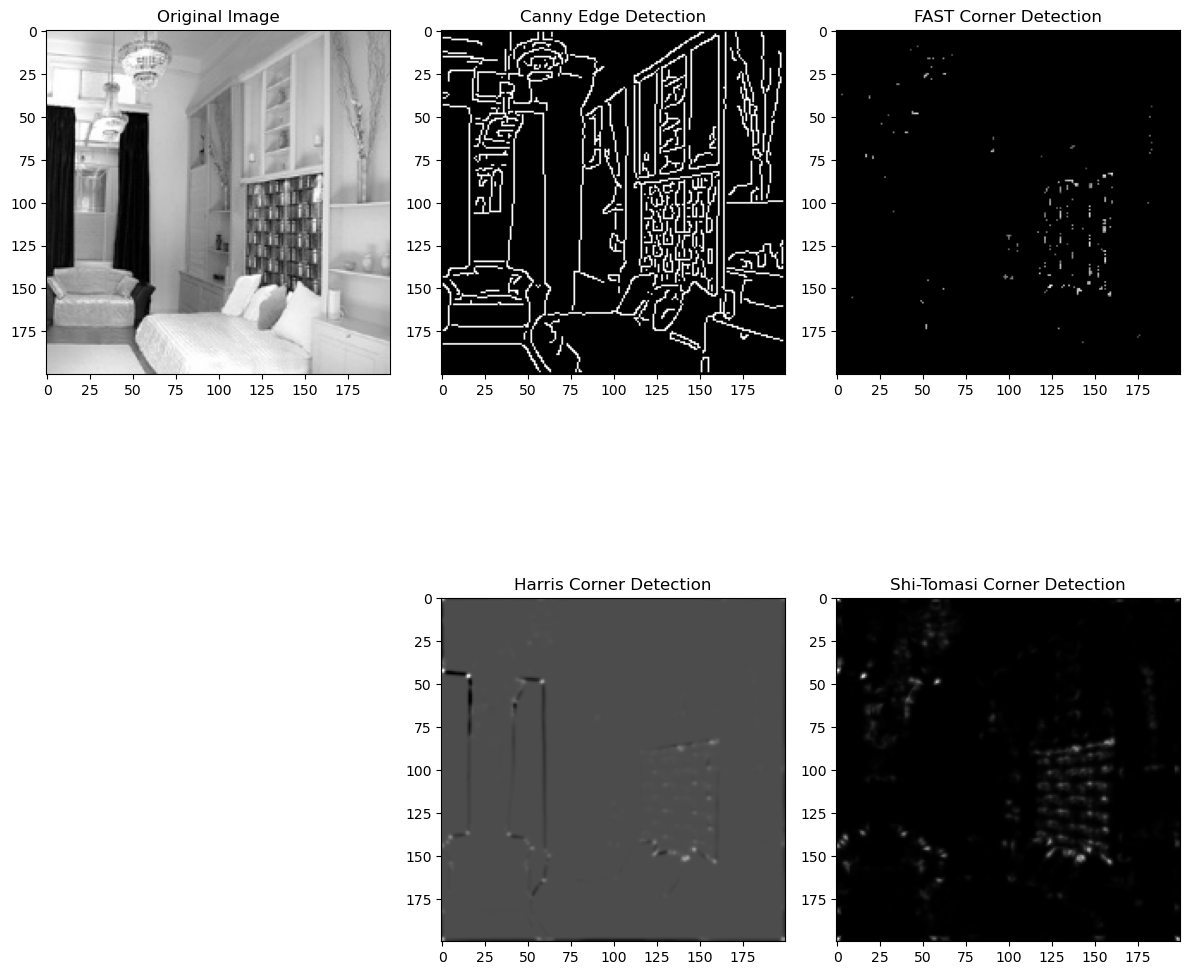

In [7]:
import cv2
from skimage.feature import canny, corner_fast, corner_foerstner, corner_harris, corner_shi_tomasi
import matplotlib.pyplot as plt

# Read the image using OpenCV
image = cv2.imread('data/train/bedroom/image_0005.jpg')

# Convert the image to grayscale if it's not already
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
canny_edges = canny(gray_image)

# Apply FAST corner detection
fast_corners = corner_fast(gray_image)

# Apply Förstner corner detection
forstner_corners = corner_foerstner(gray_image)

# Apply Harris corner detection
harris_corners = corner_harris(gray_image)

# Apply Shi-Tomasi corner detection
shi_tomasi_corners = corner_shi_tomasi(gray_image)

# Create subplots to display the transformed images
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# Canny Edge Detection
plt.subplot(2, 3, 2)
plt.imshow(canny_edges, cmap='gray')
plt.title('Canny Edge Detection')

# FAST Corner Detection
plt.subplot(2, 3, 3)
plt.imshow(fast_corners, cmap='gray')
plt.title('FAST Corner Detection')



# Harris Corner Detection
plt.subplot(2, 3, 5)
plt.imshow(harris_corners, cmap='gray')
plt.title('Harris Corner Detection')

# Shi-Tomasi Corner Detection
plt.subplot(2, 3, 6)
plt.imshow(shi_tomasi_corners, cmap='gray')
plt.title('Shi-Tomasi Corner Detection')

# Display the subplots
plt.tight_layout()
plt.show()


In [8]:
import cv2
from skimage import feature
import matplotlib.pyplot as plt

# Read the image using OpenCV
image = cv2.imread('data/train/bedroom/image_0001.jpg')

# Convert the image to grayscale if it's not already
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Local Binary Pattern (LBP)
lbp_image = feature.local_binary_pattern(gray_image, P=8, R=1, method='uniform')

# Create subplots to display the original and LBP images
plt.figure(figsize=(10, 5))
º
# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
)
plt.title('Original Image')
plt.axis('off')

# LBP Image
plt.subplot(1, 2, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern (LBP)')
plt.axis('off')

# Display the subplots
plt.tight_layout()
plt.show()


NameError: name 'o' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
import cv2
from skimage.feature import local_binary_pattern, hog, corner_harris, corner_shi_tomasi
import matplotlib.pyplot as plt

# Read the image using OpenCV
image = cv2.imread('data/train/bedroom/image_0001.jpg')

# Convert the image to grayscale if it's not already
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Local Binary Pattern (LBP)
lbp_image = local_binary_pattern(gray_image, P=8, R=1, method='uniform')

# Apply Histogram of Oriented Gradients (HOG)
hog_features, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)


# Apply Harris Corner Detection
harris_corners = corner_harris(gray_image)

# Apply Shi-Tomasi Corner Detection
shi_tomasi_corners = corner_shi_tomasi(gray_image)

# Create subplots to display the extracted features
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# LBP Image
plt.subplot(2, 3, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern (LBP)')
plt.axis('off')

# HOG Image
plt.subplot(2, 3, 3)
plt.imshow(hog_image, cmap='gray')
plt.title('Histogram of Oriented Gradients (HOG)')
plt.axis('off')


# Harris Corner Detection
plt.subplot(2, 3, 6)
plt.imshow(harris_corners, cmap='gray')
plt.title('Harris Corner Detection')
plt.axis('off')

# Display the subplots
plt.tight_layout()
plt.show()
